# CS7641 Machine Learning

### Assignment 3 - Unsupervised Learning
### Author: Vivek Agrawal


### References



## 1. Data Sets Used
First step in the process is to load all the datasets
1. https://archive.ics.uci.edu/ml/datasets/Census+Income
1. https://archive.ics.uci.edu/ml/datasets/Wine+Quality

In [1]:
#Imports
import os
import pandas as pd
import numpy as np
import random
import itertools 
from scipy import linalg
import matplotlib as mpl
from scipy.stats import kurtosis,entropy

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


import matplotlib.pyplot as plt
from time import clock
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from collections import defaultdict, Counter
from sklearn.metrics import adjusted_mutual_info_score as ami, accuracy_score as acc
from sklearn.metrics import homogeneity_score, completeness_score, homogeneity_completeness_v_measure
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import SparseRandomProjection
from itertools import product
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.base import TransformerMixin,BaseEstimator
import scipy.sparse as sps
from scipy.linalg import pinv
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.simplefilter('ignore')
from sklearn.preprocessing import OneHotEncoder, scale, KBinsDiscretizer



# Data Cleanup

In [2]:
def gtid():
    return 903471711

def author(self):
    return 'vagrawal63'	

  
def get_income_data(file_name = "adult.csv"):
    data = pd.read_csv(file_name)
    #clean rows with empty values 
    data = data[data.occupation.str.strip() != '?']
    data = data[data.workclass.str.strip() != '?']
    data = data[data.nativecountry.str.strip() != '?']
    #convert income to binary classes
    def func(x):
        if(x == " <=50K" or x == " <=50K."):
            return 0
        elif(x == " >50K" or x == ' >50K.'):
            return 1
    data['income'] = data['income'].apply(func)
    #print(data.head())
    result = data['income']
    del data['income']
    del data['education']
    del data['fnlwgt']
    #testing if I want to delete these additional columns
    # result: Tree size drops from Cleaned: (45222, 486) to (45222, 268)
    # accuracy drops from Accuracy of tree (No pruning):0.823377120460988 to 0.7842997385726206
    del data['capitalgain']
    del data['capitalloss']
    #encode to binary values
    #enc = OneHotEncoder(sparse = False, handle_unknown='ignore')
    #data = enc.fit_transform(data)
    data = pd.get_dummies(data, columns=['workclass','maritalstatus','occupation',
                                         'relationship','race',
                                         'gender','nativecountry'])
    
    #print(enc.categories_)
    data = scale(data)
    return data, result


#randomize using GT ID
np.random.seed(gtid())
#Read Data File
income_data, result = get_income_data()
print("Cleaned: " + str(income_data.shape))

Cleaned: (45222, 85)


In [3]:
print("Split data")
#split data
X_train, X_test, Y_train, Y_test = train_test_split(income_data, result, test_size  = 0.2)
print("X_train: " + str(X_train.shape))

Split data
X_train: (36177, 85)


## Part 1: K Means and GMM (Expectation Maximization)

In [4]:
print('Part 1: Start Clustering on Income Data ==')
clusters =  [2,4,6,8,10,12,14,16,18,20,25,30]


SSE = defaultdict(dict)
BIC = defaultdict(dict)
hScore = defaultdict(dict)
cScore = defaultdict(dict)
AMI = defaultdict(dict)
VMeasure = defaultdict(dict)
km = KMeans(random_state=5)
gmm = GaussianMixture(random_state = 100)

st = clock()
for k in clusters:
    km.set_params(n_clusters=k)
    gmm.set_params(n_components=k)
    
    #km = km.fit(X_train)
    km.fit(X_train)
    gmm.fit(X_train)

    SSE[k]['IncomeInertia'] = (km.inertia_)
    BIC[k]['IncomeBIC'] = gmm.bic(X_train)
    
    hScore[k]['KM'] = homogeneity_score(Y_train,km.predict(X_train))
    hScore[k]['GMM'] = homogeneity_score(Y_train,gmm.predict(X_train))
    
    cScore[k]['KM'] = completeness_score(Y_train,km.predict(X_train))
    cScore[k]['GMM'] = completeness_score(Y_train,gmm.predict(X_train))
    
    AMI[k]['KM'] = ami(Y_train,km.predict(X_train))
    AMI[k]['GMM'] = ami(Y_train,gmm.predict(X_train))
    
    
    a,b,vm = homogeneity_completeness_v_measure(Y_train,km.predict(X_train))
    VMeasure[k]['KM'] = vm
    
    a,b,vm = homogeneity_completeness_v_measure(Y_train,gmm.predict(X_train))
    VMeasure[k]['GMM'] = vm
    #print(k, clock()-st)
    
    
SSE = (pd.DataFrame(SSE)).T
BIC = pd.DataFrame(BIC).T

hScore = pd.DataFrame(hScore).T 
cScore = pd.DataFrame(cScore).T
AMI = pd.DataFrame(AMI).T
VMeasure = pd.DataFrame(VMeasure).T

print("Writing files now .. ")
SSE.to_csv('./P1/IncomeClusterKMeans.csv')
BIC.to_csv('./P1/IncomeClusterGMM.csv')

hScore.to_csv('./P1/IncomeHScore.csv')
cScore.to_csv('./P1/IncomeCScore.csv')
AMI.to_csv('./P1/IncomeAMI.csv')
VMeasure.to_csv('./P1/IncomeVMeasure.csv')
print("Finished writing files")

Part 1: Start Clustering on Income Data ==
Writing files now .. 
Finished writing files


In [5]:
# Plotting methods for Model evaluation

def plot_clustering_charts():

    
    KNNCluster = pd.read_csv("./P1/IncomeClusterKMeans.csv", header='infer')
    GMMCluster = pd.read_csv("./P1/IncomeClusterGMM.csv", header='infer')

    HScore = pd.read_csv("./P1/IncomeHScore.csv", header = 'infer')
    CScore = pd.read_csv("./P1/IncomeCScore.csv", header = 'infer')
    AMI = pd.read_csv("./P1/IncomeAMI.csv", header = 'infer')

    VMeasure = pd.read_csv("./P1/IncomeVMeasure.csv", header = 'infer')

    x_data = HScore['Unnamed: 0']
    plt.close()
    plt.plot(x_data, KNNCluster['IncomeInertia'], 'bx-', color = 'blue', linewidth = 1, label = "Number of Clusters" )
    plt.axvline(x = 6, linestyle = "--", linewidth = 1, color = "k", label = "Optimal Clusters = 6")
    plt.legend(loc = 'best')
    plt.title("Figure 1.1: KMeans Elbow Method\nIncome Dataset")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Sum of Squared Distances");
    plt.show()
    plt.close()

    
    #plt.figure(figsize = (12,8))
    plt.plot(x_data, HScore['KM'], color = 'orange',  label = "Homogenity" )
    plt.plot(x_data, CScore['KM'], color = 'blue',  label = "Completeness" )
    plt.plot(x_data, AMI['KM'], color = 'green',  label = "Adjusted MI" )
    plt.plot(x_data, VMeasure['KM'], color = 'red',  label = "V Measure" )
    plt.axvline(x = 6 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Clusters = 6")

    plt.legend(loc = 'upper right')
    plt.title("Figure 1.2: KMeans Performance Evaluation\nIncome Dataset")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Score");
    plt.show()
    plt.close()
    # chart for GMM
    plt.plot(x_data, GMMCluster['IncomeBIC'], 'bx-', color = 'blue', linewidth = 1, label = "Number of Clusters" )
    plt.axvline(x = 8 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Clusters = 8")
    plt.legend(loc = 'best')
    plt.title("Figure 2.2: Expectation Maximization BIC\nIncome Dataset")
    plt.xlabel("Number of Clusters")
    plt.ylabel("BIC");
    plt.show()
    plt.close()


    #plt.figure(figsize = (12,8))
    plt.plot(x_data, HScore['GMM'], color = 'orange',  label = "Homogenity" )
    plt.plot(x_data, CScore['GMM'], color = 'blue',  label = "Completeness" )
    plt.plot(x_data, AMI['GMM'], color = 'green',  label = "Adjusted MI" )
    plt.plot(x_data, VMeasure['GMM'], color = 'red',  label = "V Measure" )
    plt.axvline(x = 8 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Clusters = 8")
    plt.legend(loc = 'upper right')
    plt.title("Figure 2.2: Expectation Maximization Performance Evaluation\nIncome Dataset")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Score");
    plt.show()
    plt.close()

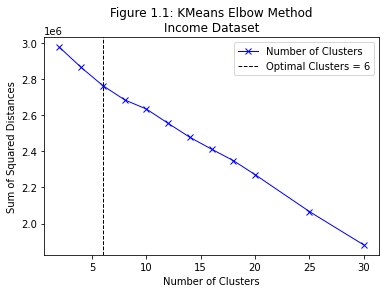

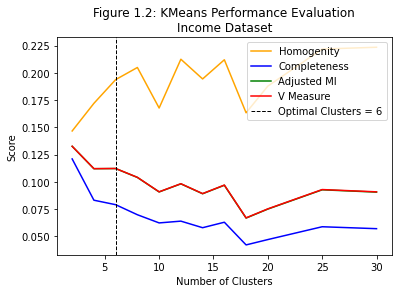

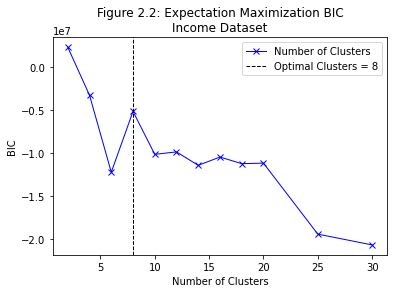

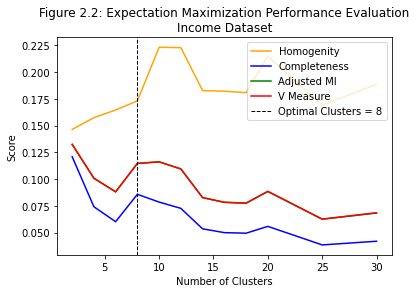

In [6]:
plot_clustering_charts()

In [4]:
def KM_Silhoutte(X, y, title=""):
    if (title == ""):
        title = "Figure 1.3: KMeans Clustering Silhoutte Analysis\nIncome Dataset "
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.


    range_n_clusters = [2,4,6,8,10,12,14,16,18,20,25,30]

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(12,5)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        #ax1.set_title("Figure 1c: kMeans silhouette plot (Cancer Dataset)")
        ax1.set_xlabel("Silhouette coefficient values")
        #ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label="Average Silhouette Score")

        #ax1.set_yticks([])  # Clear the yaxis labels / ticks
        #ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        #ax2.set_title("The visualization of the clustered data.")
        #ax2.set_xlabel("Feature space for the 1st feature")
        #ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle((title+
                      "(No of Clusters = %d)" % n_clusters),
                     fontsize=14)

    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.08110637215591078
For n_clusters = 4 The average silhouette_score is : 0.0915342836113496
For n_clusters = 6 The average silhouette_score is : 0.09208082524359344
For n_clusters = 8 The average silhouette_score is : 0.11764319659397879
For n_clusters = 10 The average silhouette_score is : 0.11042154518705376
For n_clusters = 12 The average silhouette_score is : 0.09650700755647856
For n_clusters = 14 The average silhouette_score is : 0.09770631887721046
For n_clusters = 16 The average silhouette_score is : 0.10054829888800336
For n_clusters = 18 The average silhouette_score is : 0.10288112640946283
For n_clusters = 20 The average silhouette_score is : 0.09517790508037315
For n_clusters = 25 The average silhouette_score is : 0.10036635708077063
For n_clusters = 30 The average silhouette_score is : 0.112424752971776


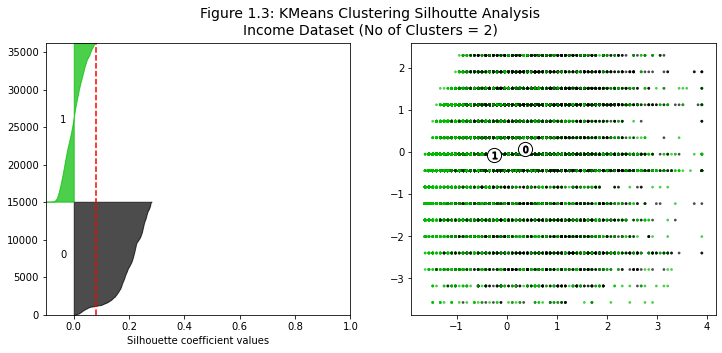

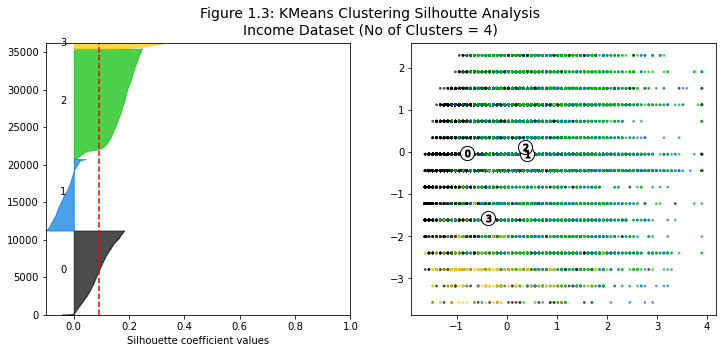

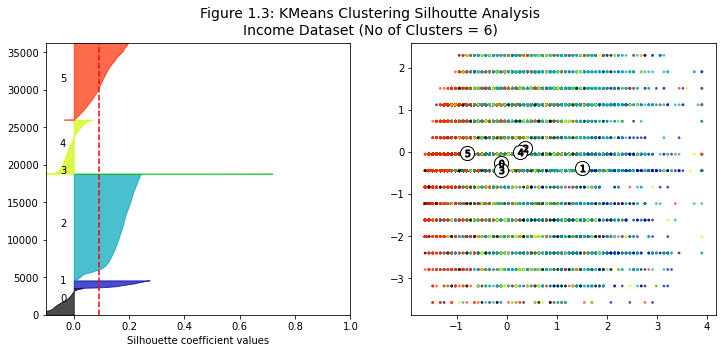

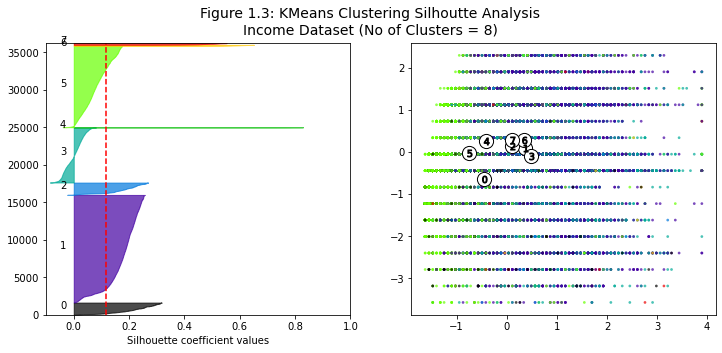

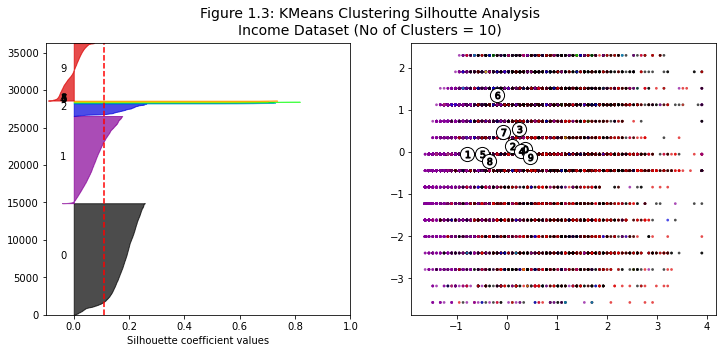

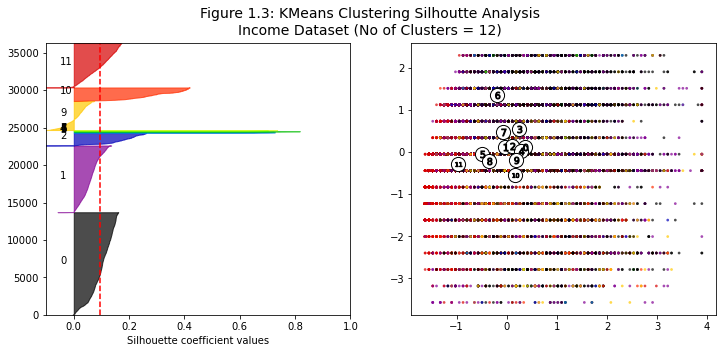

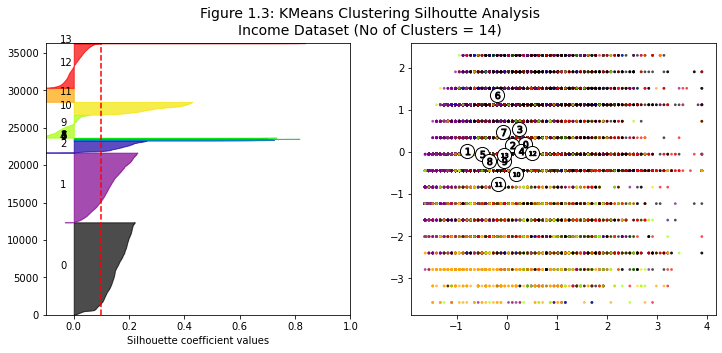

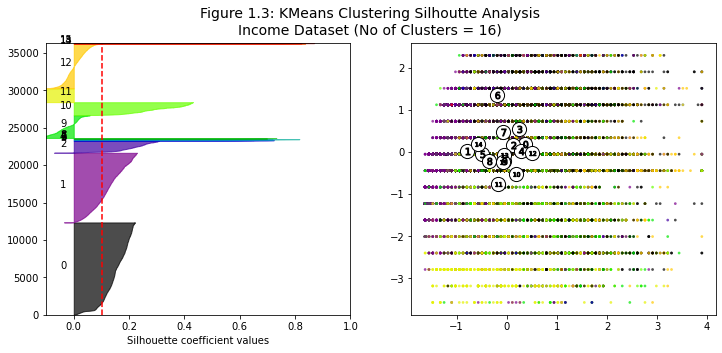

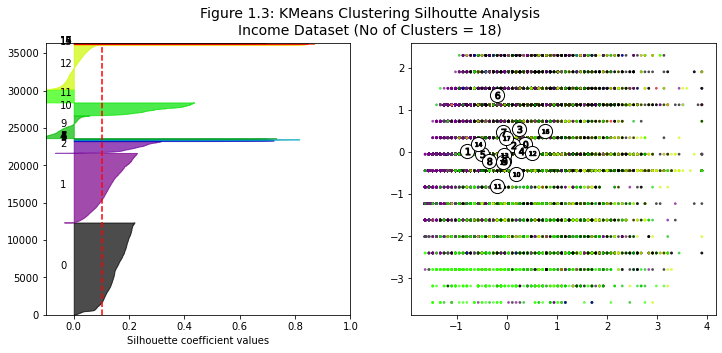

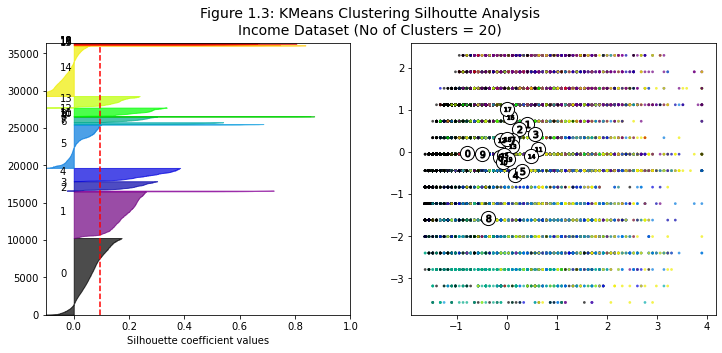

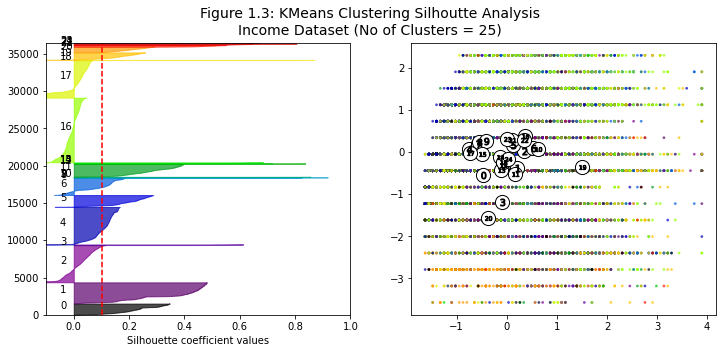

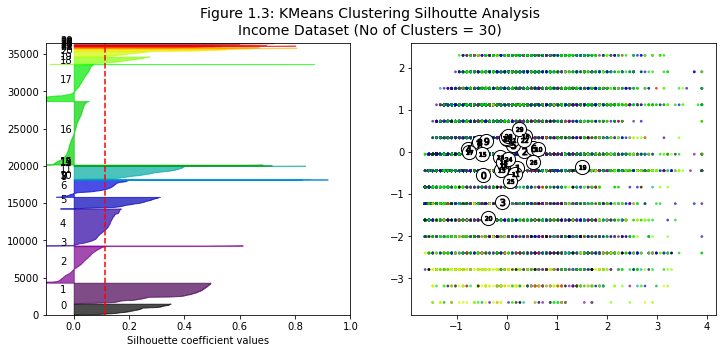

In [8]:
KM_Silhoutte(X_train, Y_train)

In [5]:
def compute_bic_score(X,title1, title2):
    lowest_bic = np.infty
    bic = []
    n_components_range = [2,4,6,8,10,12,14,16,18,20,25,30]
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            print("CV Type: ", cv_type, " Components: ", n_components, " BIC Score: ", bic[-1])
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)
    color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                                  'darkorange'])

    print("Lowest BIC score = ", lowest_bic)
    # Plot the BIC scores
    plt.figure(figsize=(8, 6))
    clf = best_gmm
    bars = []
    spl = plt.subplot(2, 1, 1)
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                            width=.2, color=color))
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title(title1)
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
        .2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types)
    #plt.show()
    #plt.close()

    # Plot the winner
    #4splot = plt.subplot(2, 1, 2)
    Y_ = clf.predict(X)
    '''
    for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                               color_iter)):
        v, w = linalg.eigh(cov)
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan2(w[0][1], w[0][0])
        angle = 180. * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(.5)
        splot.add_artist(ell)
    
    plt.xticks(())
    plt.yticks(())
    plt.title(title2)
    plt.subplots_adjust(hspace=.35, bottom=.02)
    '''
    plt.show()
    plt.close()

CV Type:  spherical  Components:  2  BIC Score:  6986357.835567656
CV Type:  spherical  Components:  4  BIC Score:  6301800.529800977
CV Type:  spherical  Components:  6  BIC Score:  6216695.238015352
CV Type:  spherical  Components:  8  BIC Score:  6253487.832445498
CV Type:  spherical  Components:  10  BIC Score:  6071034.133540242
CV Type:  spherical  Components:  12  BIC Score:  5552332.828328814
CV Type:  spherical  Components:  14  BIC Score:  5825394.034088218
CV Type:  spherical  Components:  16  BIC Score:  5718000.2836795645
CV Type:  spherical  Components:  18  BIC Score:  5766725.530743908
CV Type:  spherical  Components:  20  BIC Score:  5283461.915350778
CV Type:  spherical  Components:  25  BIC Score:  5126753.131470406
CV Type:  spherical  Components:  30  BIC Score:  4862206.349551855
CV Type:  tied  Components:  2  BIC Score:  4442495.421451039
CV Type:  tied  Components:  4  BIC Score:  3883012.383777547
CV Type:  tied  Components:  6  BIC Score:  3497845.6874665776


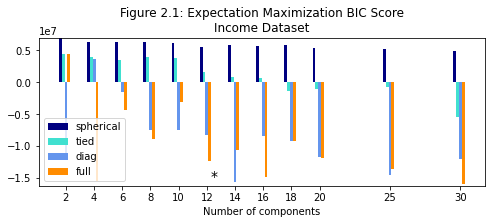

In [10]:
compute_bic_score(X_train, "Figure 2.1: Expectation Maximization BIC Score\nIncome Dataset" , "Figure 2.2: Cluster Representation\nIncome Dataset")

## Part 2: Dimensionality Reduction (PCA, ICA, RP and SVD)

In [8]:
dimensions = range(1, 85)
ann_learning_rate = [0.05]
ann_hidden_layers = [(8)]

def run_ann(dimensions, classifier, X, Y):
    grid ={'clf__n_components':dimensions,'NN__learning_rate_init':ann_learning_rate,'NN__hidden_layer_sizes':ann_hidden_layers}      
    ann = MLPClassifier(activation='logistic',max_iter=2000,early_stopping=True,random_state=5)
    pipe = Pipeline([('clf',classifier),('NN',ann)])
    gs = GridSearchCV(pipe,grid,verbose=2,cv=5)
    gs.fit(X, Y)

    #print("Best Estimator : ", gs.best_estimator_)
    #print("Best Parameters: ", gs.best_params_)
    
    return (pd.DataFrame(gs.cv_results_) , gs.best_estimator_)

In [12]:
print('Part 2: PCA for Income dataset')
pca = PCA(random_state = 5)
pca.fit_transform(X_train)
EVR = pd.Series(data = pca.explained_variance_ratio_,index = range(0,85))
EVR.to_csv('./P2/IncomePCA-EVR.csv')
EV = pd.Series(data = pca.explained_variance_,index = range(0,85))
EV.to_csv('./P2/IncomePCA-EV.csv')


pca = PCA(random_state = 5)  
nn_results, clf = run_ann(dimensions, pca, X_train, Y_train)     
nn_results.to_csv('./P2/IncomePCA_ANN.csv')

## test score

test_score = clf.score(X_test, Y_test)
print("Test Accuracy  : ", test_score )
print("Best Estimator : ", clf)

Part 2: PCA for Income dataset
Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   3.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   3.9s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   1.5s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   1.8s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   1.9s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=2, total=   4.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=2, total=   4.8s
[CV] NN__hidden_lay

[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed: 20.7min finished


Test Accuracy  :  0.8312880044223327
Best Estimator :  Pipeline(steps=[('clf', PCA(n_components=24, random_state=5)),
                ('NN',
                 MLPClassifier(activation='logistic', early_stopping=True,
                               hidden_layer_sizes=8, learning_rate_init=0.05,
                               max_iter=2000, random_state=5))])


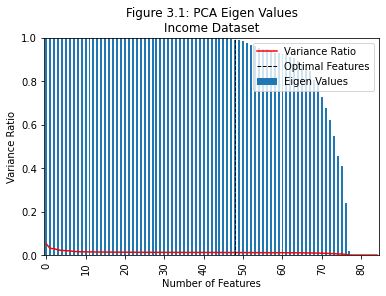

Reduced Dimension: 82 out of 85
Variance captured: 11.169802345352796 %


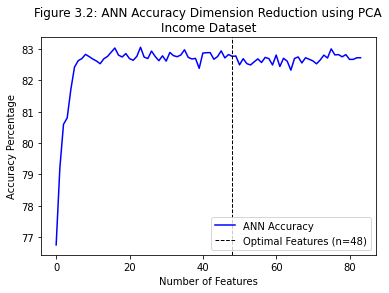

In [13]:
EVR.plot( ylim = (0.,0.35), color = 'red',  label = "Variance Ratio" )

ax = EV.plot(kind = 'bar',ylim = (0.,1.0),label = "Eigen Values")

ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::10])
ax.xaxis.set_ticklabels(ticklabels[::10]);
ax.axvline(x = 48 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Features")

plt.legend(loc=1)
plt.title("Figure 3.1: PCA Eigen Values\nIncome Dataset")
plt.xlabel("Number of Features")
plt.ylabel("Variance Ratio");
plt.show()
plt.close()

print("Reduced Dimension: {} out of {}".
      format(X_train.shape[1]-len([i for i in EVR if i >= 0.025]),X_train.shape[1]))
print("Variance captured: {} %".format(sum([i for i in EVR if i >= 0.025])*100.))

nn_pca = pd.read_csv("./P2/IncomePCA_ANN.csv", header = 'infer')
nn_pca = nn_results['mean_test_score'] * 100.0

nn_pca.plot( color = 'blue',  label = "ANN Accuracy" )
plt.axvline(x = 48 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Features (n=48)")

plt.legend(loc='best')
plt.title("Figure 3.2: ANN Accuracy Dimension Reduction using PCA\nIncome Dataset")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy Percentage");
plt.show()
plt.close()


In [14]:
ica = FastICA(random_state=5)
temp = ica.fit_transform(X_train)
order = [-abs(kurtosis(temp[:,i])) for i in range(temp.shape[1])]
temp = temp[:,np.array(order).argsort()]
kurt =  pd.Series([abs(kurtosis(temp[:,i])) for i in range(temp.shape[1])]);

# Run Neural Networks
ica = FastICA(random_state=5)  
nn_results , clf = run_ann(dimensions, ica, X_train, Y_train)     
nn_results.to_csv('./P2/IncomeICA_ANN.csv')

## test score

test_score = clf.score(X_test, Y_test)
print("Test Accuracy  : ", test_score )
print("Best Estimator : ", clf)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   3.9s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   2.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   3.0s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   2.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   2.0s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=2, total=   2.6s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=2, total=   2.6s
[CV] NN__hidden_lay

[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed: 64.3min finished


Test Accuracy  :  0.8338308457711443
Best Estimator :  Pipeline(steps=[('clf', FastICA(n_components=77, random_state=5)),
                ('NN',
                 MLPClassifier(activation='logistic', early_stopping=True,
                               hidden_layer_sizes=8, learning_rate_init=0.05,
                               max_iter=2000, random_state=5))])


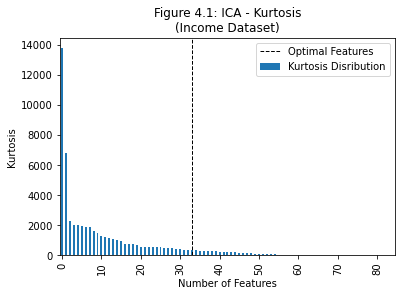

Reduced Dimension: 17 out of 85


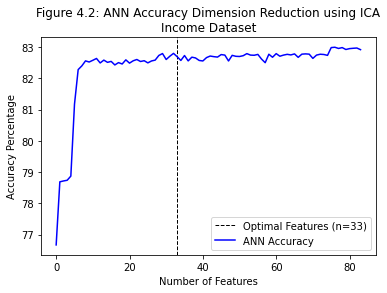

In [15]:
plt.figure(figsize=(6,4))
ax = kurt.plot(kind = 'bar', label = "Kurtosis Disribution");
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::10])
ax.xaxis.set_ticklabels(ticklabels[::10]);
ax.axvline(x=33 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Features")


plt.legend(loc='best')
plt.title("Figure 4.1: ICA - Kurtosis\n(Income Dataset)")
plt.xlabel("Number of Features")
plt.ylabel("Kurtosis");
plt.show()
plt.close()
print("Reduced Dimension: {} out of {}".format(X_train.shape[1]-len([i for i in kurt if i >= 8.]),
                                               X_train.shape[1]))

nn_ica = pd.read_csv("./P2/IncomeICA_ANN.csv", header = 'infer')
nn_ica = nn_results['mean_test_score'] * 100.0
plt.axvline(x=33 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Features (n=33)")

nn_ica.plot( color = 'blue',  label = "ANN Accuracy" )

plt.legend(loc='best')
plt.title("Figure 4.2: ANN Accuracy Dimension Reduction using ICA\nIncome Dataset")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy Percentage");
plt.show()
plt.close()



In [6]:
def distance_correlation (X1,X2):
    assert X1.shape[0] == X2.shape[0]
    return np.corrcoef(pairwise_distances(X1).ravel(),pairwise_distances(X2).ravel())[0,1]

In [9]:
tmp = defaultdict(dict)
#for i,dim in product(range(10),dimensions):
for i,dim in product(range(2),dimensions):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    tmp[dim][i] = distance_correlation(rp.fit_transform(X_train), X_train)

tmp = pd.DataFrame(tmp).T
tmp.to_csv('./P2/AdultRP_DistanceCorrelation.csv')



In [10]:
# Run Neural Networks
rp = SparseRandomProjection(random_state=5) 
nn_results, clf = run_ann(dimensions, rp,  X_train, Y_train)     
nn_results.to_csv('./P2/AdultRP_ANN.csv')

## test score
test_score = clf.score(X_test, Y_test)
print("Test Accuracy = ", test_score )
print("Best Estimator = ", clf)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   1.8s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   1.7s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   1.6s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   1.6s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   1.5s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=2, total=   1.6s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=2, total=   1.5s
[CV] NN__hidden_lay

[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed: 21.1min finished


Test Accuracy =  0.8311774461028192
Best Estimator =  Pipeline(steps=[('clf',
                 SparseRandomProjection(n_components=77, random_state=5)),
                ('NN',
                 MLPClassifier(activation='logistic', early_stopping=True,
                               hidden_layer_sizes=8, learning_rate_init=0.05,
                               max_iter=2000, random_state=5))])


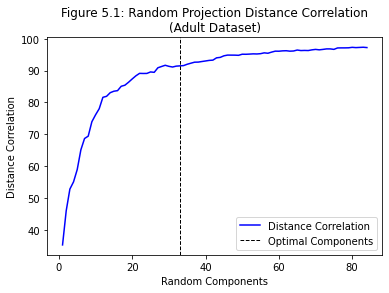

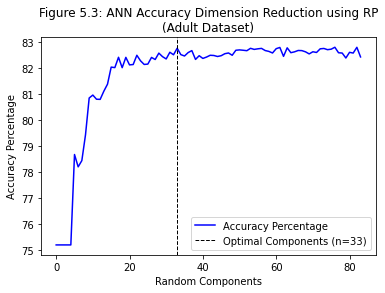

In [17]:
tmp['mean'] = tmp.mean(axis=1)

distance = tmp['mean']*100.0

distance.plot(color = 'blue',  label = "Distance Correlation" )
plt.axvline(x=33 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components")

plt.legend(loc='best')
plt.title("Figure 5.1: Random Projection Distance Correlation\n(Adult Dataset)")
plt.xlabel("Random Components")
plt.ylabel("Distance Correlation");
plt.show()
plt.close()


nn_results = pd.read_csv("./P2/AdultRP_ANN.csv", header = 'infer')
nn_results = nn_results['mean_test_score'] * 100.0
#nn_train_results_pca = nn_results['mean_train_score'] * 100.0
nn_results.plot( color = 'blue',  label = "Accuracy Percentage" )
plt.axvline(x=33 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components (n=33)")

plt.legend(loc='best')
plt.title("Figure 5.3: ANN Accuracy Dimension Reduction using RP\n(Adult Dataset)")
plt.xlabel("Random Components")
plt.ylabel("Accuracy Percentage");
plt.show()
plt.close()

In [ ]:
# http://datascience.stackexchange.com/questions/6683/feature-selection-using-feature-importances-in-random-forests-with-scikit-learn          
class ImportanceSelect(BaseEstimator, TransformerMixin):
    def __init__(self, model, n=1):
         self.model = model
         self.n = n
    def fit(self, *args, **kwargs):
         self.model.fit(*args, **kwargs)
         return self
    def transform(self, X):
         return X[:,self.model.feature_importances_.argsort()[::-1][:self.n]]


In [ ]:
rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=5, n_jobs=-1)

result = rfc.fit(X_train, Y_train).feature_importances_ 

tmp = pd.Series(np.sort(result)[::-1])
tmp.to_csv('./P2/IncomeRF_FI.csv')

In [ ]:
ann_learning_rate = [0.05]
ann_hidden_layers = [(8)]

rfc = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=5,n_jobs=-1)
filtr = ImportanceSelect(rfc)
grid ={'filter__n':dimensions,'NN__learning_rate_init':ann_learning_rate,'NN__hidden_layer_sizes':ann_hidden_layers}  
ann = MLPClassifier(activation='logistic',max_iter=2000,early_stopping=True,random_state=5)
pipe = Pipeline([('filter',filtr),('NN',ann)])
gs = GridSearchCV(pipe,grid,verbose=10,cv=5)
gs.fit(X_train, Y_train)
nn_results = pd.DataFrame(gs.cv_results_)
nn_results.to_csv('./P2/IncomeRF_ANN.csv')

#print("best estimator = ", gs.best_estimator_)
#print("best params = ", gs.best_params_)

In [ ]:
df1 = pd.read_csv("./P2/IncomeRF_FI.csv", header=None)
x_data = df1[0] 

plt.figure(figsize = (12,8))
fig, ax1 = plt.subplots()
ax1.plot(x_data, df1[1]* 100.0, label = "Feature Importance" , color = "blue",)
ax1.axvline(x=32 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Cluster")
#reatins 90% feature importance
#plt.legend(loc='center right')

ax2 = ax1.twinx() 
ax2.plot(x_data, df1[2]*100.0, label = "Cumulative Importance" , color = "green",)

#ax1.legend(loc='center right')
fig.legend(loc='center left', bbox_to_anchor=(0.5, 0.5))
plt.title("Figure 6.1: Random Forest Feature Importance \nIncome Dataset")
ax1.set_xlabel("Number of Features")
ax1.set_ylabel("Feature Importance Percent")
ax2.set_ylabel("Cumulative Importance Percent")
fig.tight_layout() 

plt.show()
plt.close()

In [ ]:
nn_results = pd.read_csv("./P2/IncomeRF_ANN.csv", header = 'infer')
nn_results = nn_results['mean_test_score'] * 100.0
#nn_train_results_pca = nn_results['mean_train_score'] * 100.0
nn_results.plot( color = 'blue',  label = "Accuracy Percentage" )
plt.axvline(x=32 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Features (n=32)")

plt.legend(loc='best')
plt.title("Figure 6.2: ANN Accuracy Dimension Reduction using RF\nIncome Dataset")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy Percentage");
plt.show()
plt.close()

clf = gs.best_estimator_
## test score

test_score = clf.score(X_test, Y_test)
#print("Test Accuracy = ", test_score )
#print("Best Estimator = ", clf)

## Part 3: Clustering after reducing dimensions

In [ ]:
dimensions_PCA = 48 
dimensions_ICA = 33 
dimensions_RP = 32 
dimensions_RF = 32

rfc = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', random_state =5, n_jobs = -1)

algo_name = ['PCA', 'ICA', 'RP', 'RF']

filter_ = ImportanceSelect(rfc,dimensions_RF)

algos = [PCA(n_components=dimensions_PCA,random_state=10), 
           FastICA(n_components=dimensions_ICA,random_state=10), 
           SparseRandomProjection(n_components=dimensions_RP,random_state=5),
           ImportanceSelect(rfc,dimensions_RF)]

for i in range(len(algos)):
    if i == 3:
        X2 = algos[i].fit_transform(X_train, Y_train)
    else:   
        X2 = algos[i].fit_transform(X_train)
    data2 = pd.DataFrame(np.hstack((X2,np.atleast_2d(Y_train).T)))
    cols = list(range(data2.shape[1]))
    cols[-1] = 'Class'
    data2.columns = cols
    data2.to_hdf('datasets.hdf','Income_'+algo_name[i],complib='blosc',complevel=9)

In [ ]:
#random.seed(55)
titles = ["Figure 7.1: KMeans Clustering with PCA\nIncome Dataset ",
          "Figure 7.2: KMeans Clustering with ICA\nIncome Dataset ",
          "Figure 7.3: KMeans Clustering with RP\nIncome Dataset ",
          "Figure 7.4: KMeans Clustering with RF\nIncome Dataset "]

titles_bic_1 = ["Figure 7.5: Expectation Maximization with PCA\nIncome Dataset ",
          "Figure 7.6: Expectation Maximization with ICA\nIncome Dataset ",
          "Figure 7.7: Expectation Maximization with RP\nIncome Dataset ",
          "Figure 7.8: Expectation Maximization with RF\nIncome Dataset "]

titles_bic_2 = "Cluster Representation"

algo_name = ['PCA', 'ICA', 'RP', 'RF']
for i in range(len(algo_name)):
    # load datasets      
    temp = pd.read_hdf('datasets.hdf','Income_'+algo_name[i]) 
    print(temp.columns)
    tempX = temp.drop('Class',1).copy().values
    tempY = temp['Class'].copy().values
    
    tempX = StandardScaler().fit_transform(tempX)
    
    KM_Silhoutte(tempX, tempY, titles[i])
    compute_bic_score(tempX , titles_bic_1[i], titles_bic_2)